In [67]:
import acoular as ac # type: ignore
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore
from uma16_acoustic_camera.config import uma16_index
import time
from scipy.signal import butter, lfilter, welch # type: ignore

In [68]:
ac.config.global_caching = 'none'

In [74]:
device_index = uma16_index()

dev = ac.SoundDeviceSamplesGenerator(
    device=device_index, 
    numchannels=16,
)

recording_time = 1 
dev.numsamples = int(recording_time * dev.sample_freq)

time.sleep(1)
signal = ac.tools.return_result(dev, num=256)

t = np.arange(signal.shape[0]) / dev.sample_freq
fs = dev.sample_freq #Abtastrate
df = 1/fs #Zeitabstand zwischen den Samples


UMA-16 device: nanoSHARC micArray16 UAC2.0: USB Audio (hw:3,0) at index 5

{'name': 'nanoSHARC micArray16 UAC2.0: USB Audio (hw:3,0)', 'index': 5, 'hostapi': 0, 'max_input_channels': 16, 'max_output_channels': 0, 'default_low_input_latency': 0.008684807256235827, 'default_low_output_latency': -1.0, 'default_high_input_latency': 0.034829931972789115, 'default_high_output_latency': -1.0, 'default_samplerate': 44100.0} 44100.0


In [75]:
print("Shape:", signal.shape)
print("Number of Samples:", dev.numsamples)
print("Calculate back the recording time:", signal.shape[0] / dev.sample_freq)

Shape: (44100, 16)
Number of Samples: 44100
Calculate back the recording time: 1.0


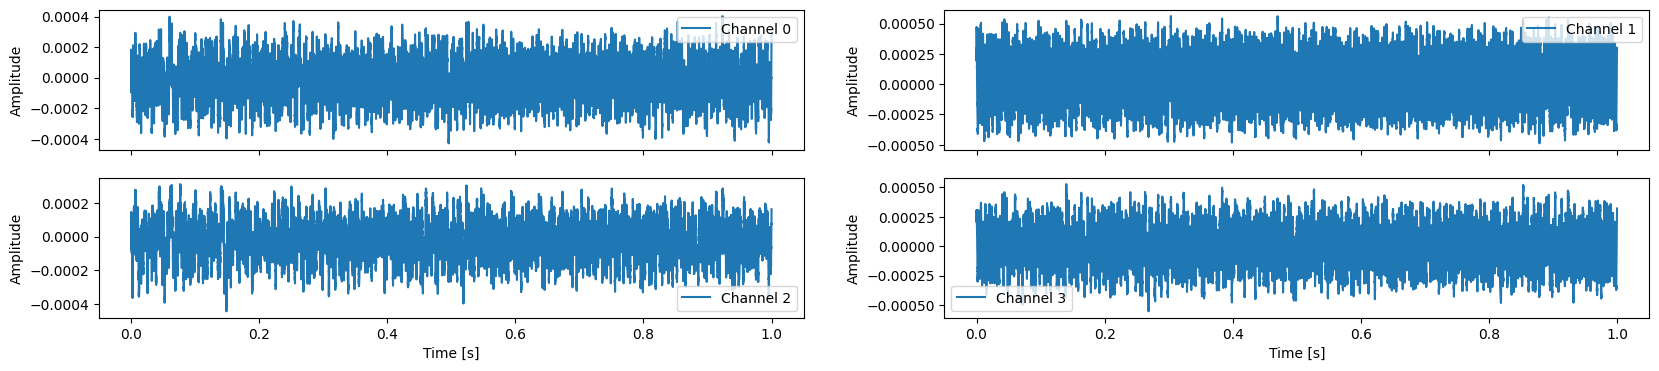

In [76]:
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(20,4))
for i in range(4):
    row = i // 2
    col = i % 2
    axs[row, col].plot(t, signal[:, i], label=f"Channel {i}")
    axs[row, col].set_ylabel("Amplitude")
    axs[row, col].legend()
axs[1, 0].set_xlabel("Time [s]")
axs[1, 1].set_xlabel("Time [s]")
plt.show()



In [77]:
freqs = np.fft.rfftfreq(signal.shape[0], d=df)
ind = np.searchsorted(freqs, 2500)
spectrum = np.fft.rfft(signal.T[0])
power_spectrum = np.real(spectrum * spectrum.conjugate())


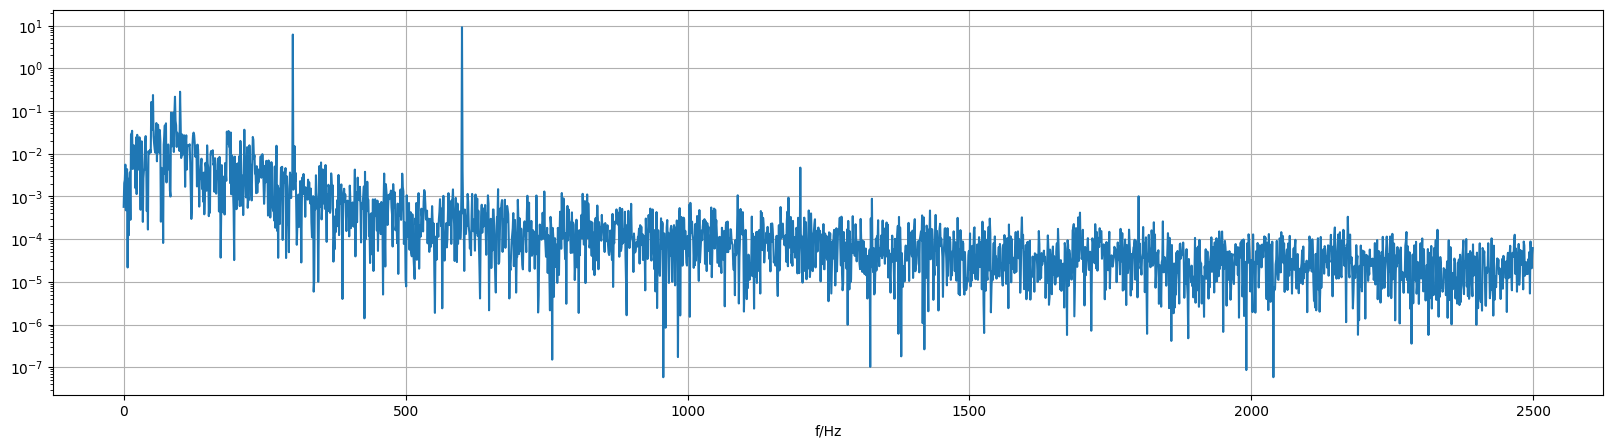

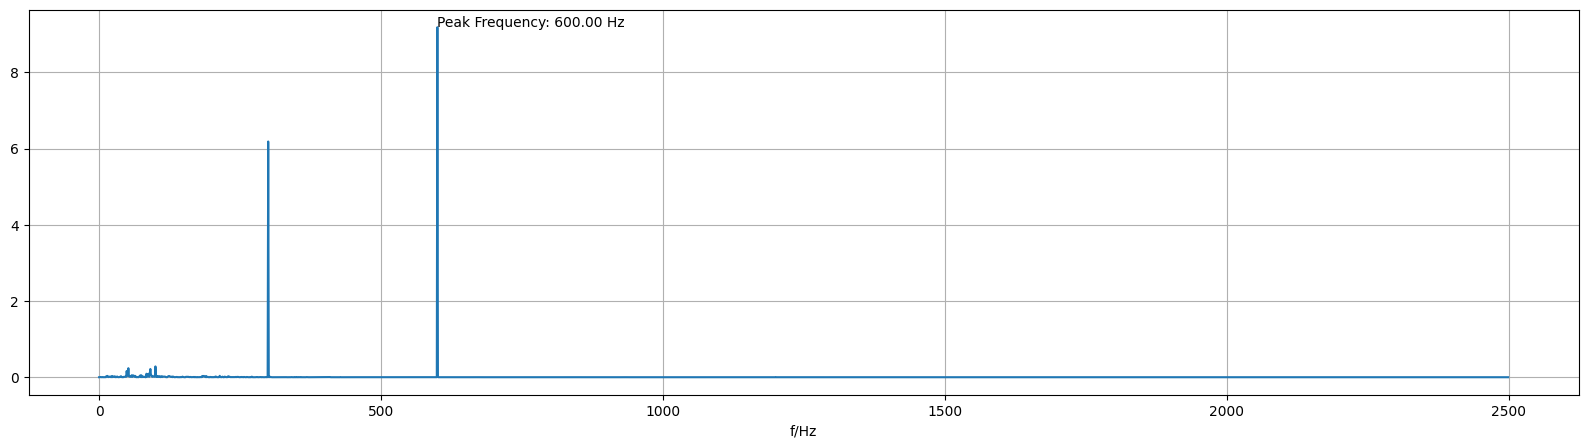

In [78]:
plt.figure(2, (20,5))
plt.plot(freqs[:ind],power_spectrum[:ind])
plt.yscale('log')
plt.xlabel('f/Hz')
plt.grid(True)
plt.show()

plt.figure(3, (20,5))
plt.plot(freqs[:ind],power_spectrum[:ind])
peak_frequency = freqs[np.argmax(power_spectrum)]
plt.annotate(f"Peak Frequency: {peak_frequency:.2f} Hz", xy=(peak_frequency, np.max(power_spectrum)))
plt.grid(True)
plt.xlabel('f/Hz')
plt.show()

In [79]:
freq_bands = [250, 315, 400, 500, 630, 800, 1000, 1250, 1600, 2000, 2500, 3150, 4000, 5000, 6300, 8000]

In [80]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

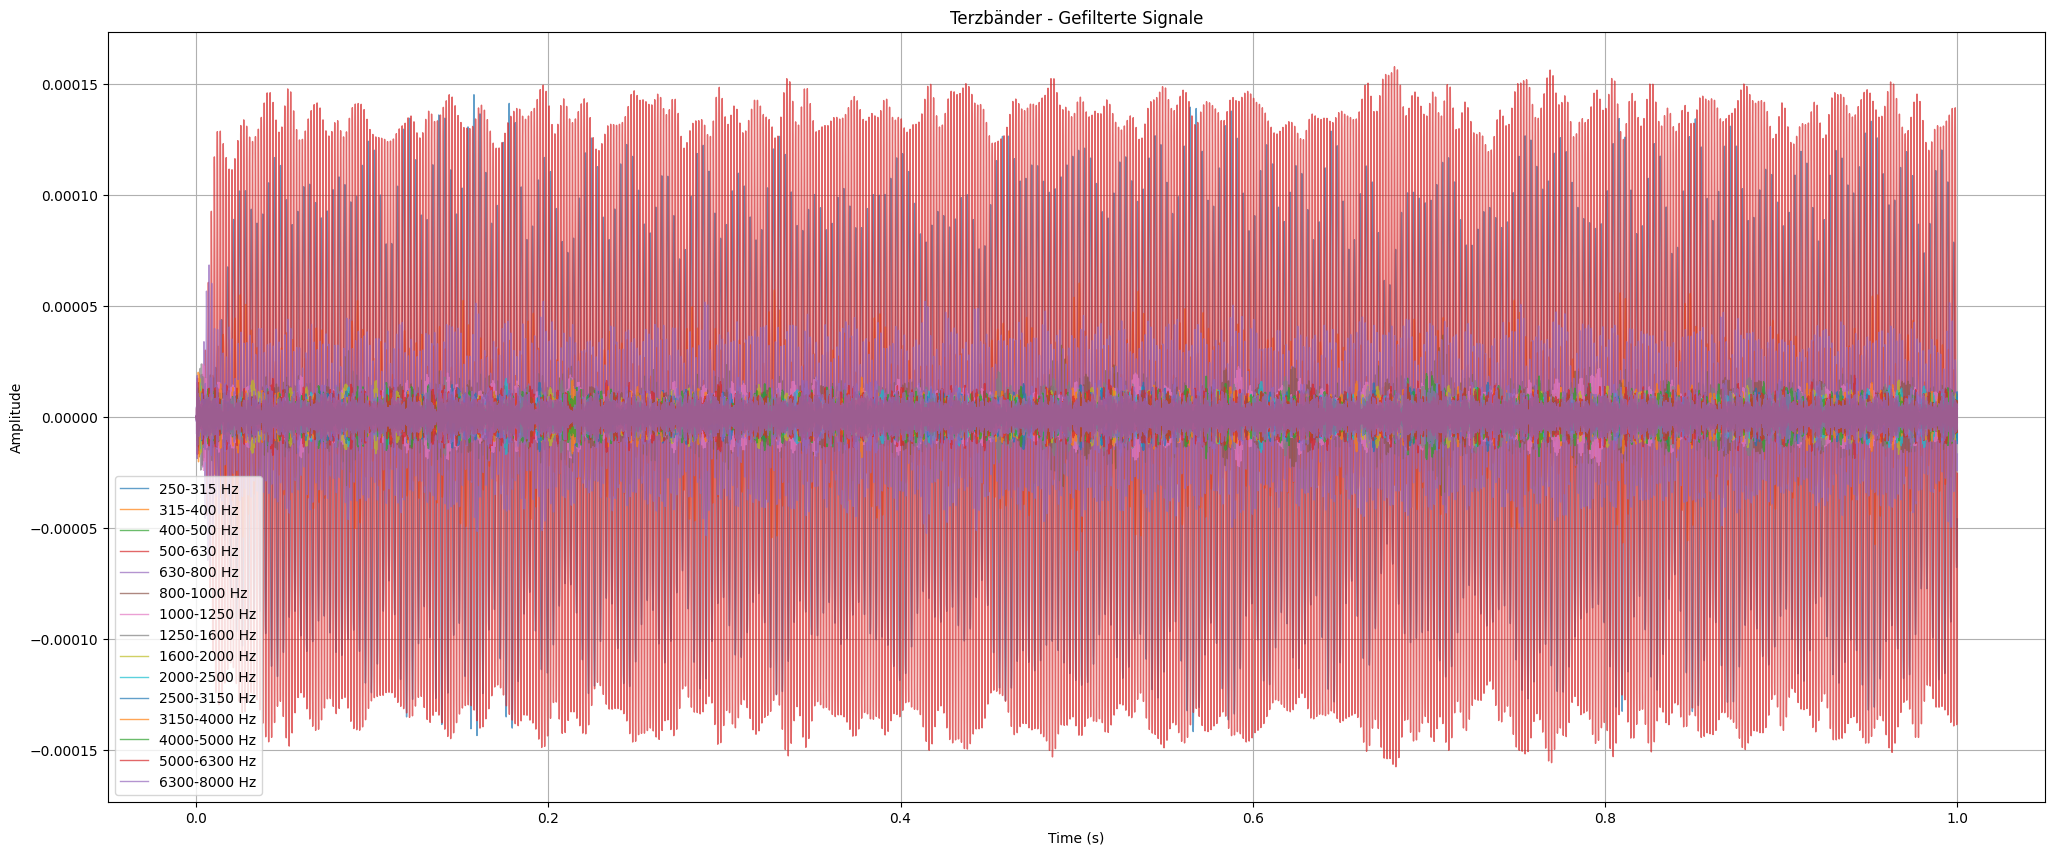

In [81]:
plt.figure(figsize=(25,10))

for i, band in enumerate(freq_bands[:-1]):
    lowcut = freq_bands[i]
    highcut = freq_bands[i+1]
    filtered_signal = bandpass_filter(signal[:, 0], lowcut, highcut, fs, order=4)

    plt.plot(t, filtered_signal, linewidth=1, label=f'{lowcut}-{highcut} Hz', alpha=0.7)  # Alpha für Transparenz

plt.title('Terzbänder - Gefilterte Signale')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

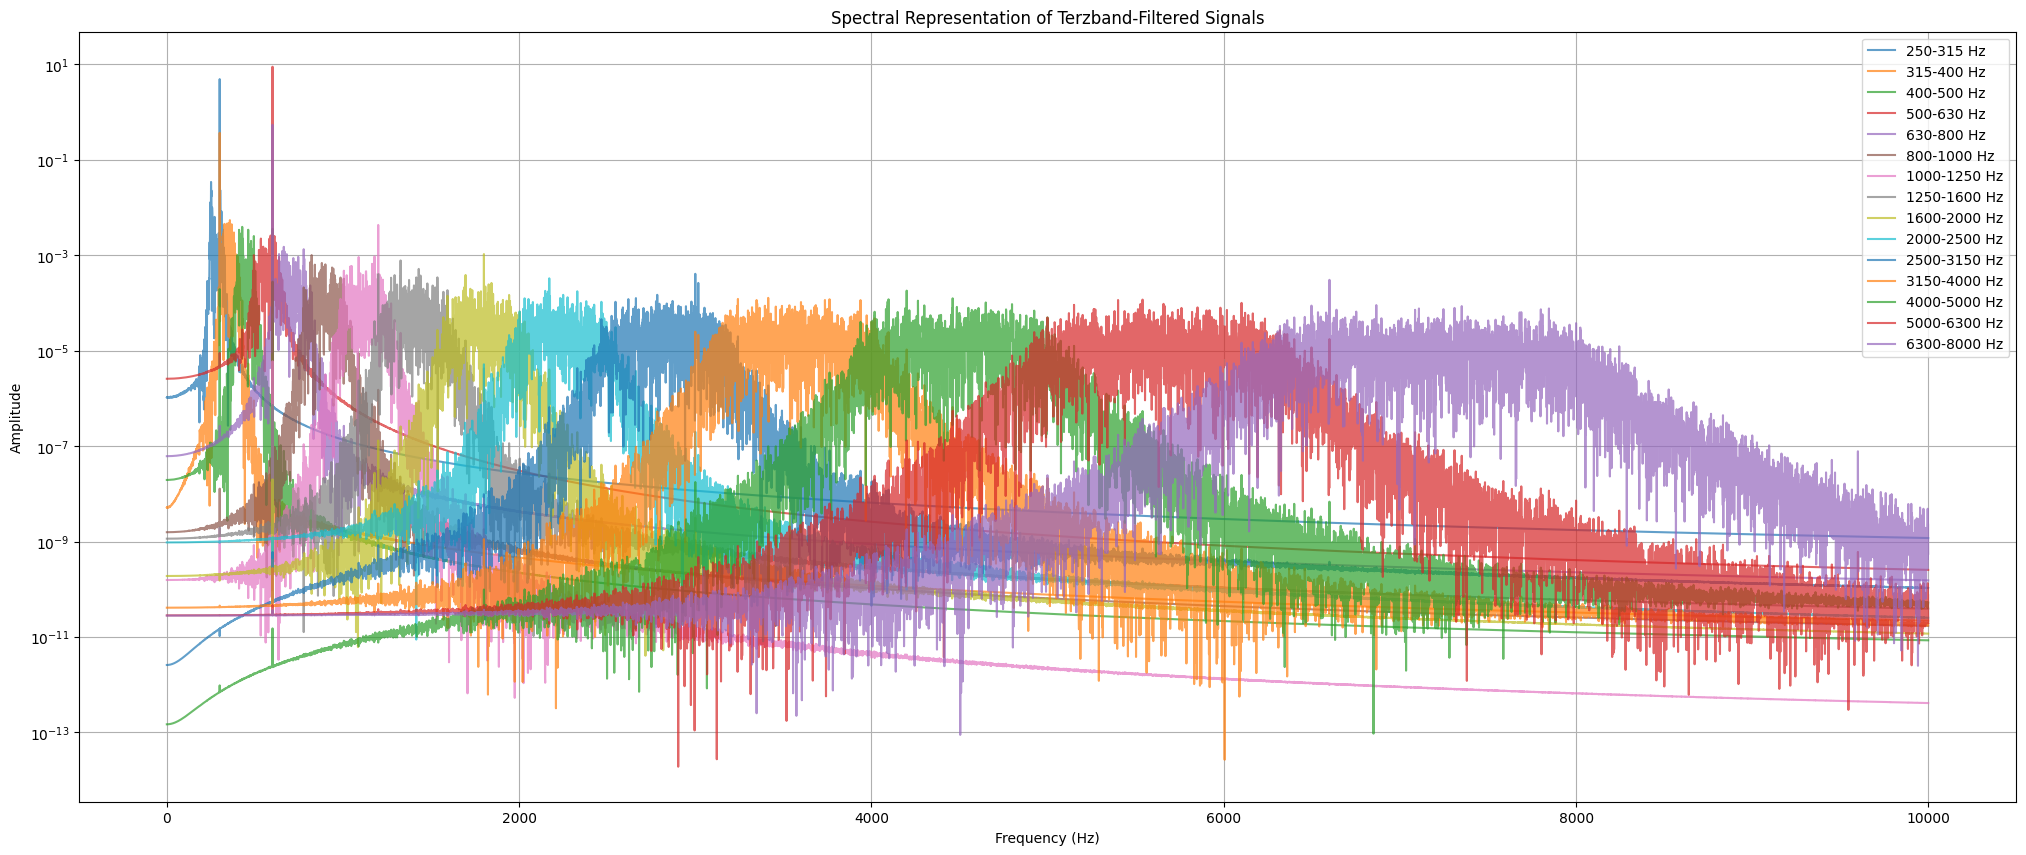

In [82]:
plt.figure(figsize=(25, 10))

ind = np.searchsorted(freqs, 10000)

for i, band in enumerate(freq_bands[:-1]):
    lowcut = freq_bands[i]
    highcut = freq_bands[i+1]
    filtered_signal = bandpass_filter(signal[:, 0], lowcut, highcut, fs, order=4)
    filtered_spectrum = np.fft.rfft(filtered_signal)
    filtered_power_spectrum = np.real(filtered_spectrum * filtered_spectrum.conjugate())
    freqs = np.fft.rfftfreq(filtered_signal.shape[0], d=df)
    plt.plot(freqs[:ind], filtered_power_spectrum[:ind], label=f'{lowcut}-{highcut} Hz', alpha=0.7)

plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Spectral Representation of Terzband-Filtered Signals')
plt.legend()
plt.grid(True)
plt.show()

In [2]:
def calculate_csm(signal):
    fft_signal = np.fft.fft(signal, axis=0)
    freq_bins = fft_signal.shape[0]
    csm = np.einsum('ij,ik->ijk', fft_signal, np.conjugate(fft_signal))
    csm = csm[:, :, :freq_bins // 2 + 1]
    
    return csm


In [86]:
def calculate_csm(signal):
    num_samples, num_mics = signal.shape
    csm = np.dot(signal.T, signal) / num_samples
    return csm

csm = calculate_csm(signal)
csm.shape

(16, 16)

In [93]:
def calculate_csm_welch(signal, fs, nperseg=None, noverlap=None):
    freqs, Pxx = welch(signal, fs=fs, nperseg=nperseg, noverlap=noverlap, axis=0)
    csm = np.einsum('ij,ik->ijk', Pxx, np.conjugate(Pxx))
    return csm, freqs

fs = 44100  # Beispielhafte Abtastrate
nperseg = 1024  # Anzahl der Samples pro Segment
noverlap = 512  # Anzahl der überlappenden Samples

csm, freqs = calculate_csm_welch(signal, fs, nperseg, noverlap)


In [94]:
csm.shape

(513, 16, 16)